In [1]:
import os

os.chdir('/home/adeel/world-bank-rai-toolkit/')
os.path.realpath(os.curdir)

'/home/adeel/world-bank-rai-toolkit'

In [93]:
# Calculate RAI for Guatemala
import numpy as np
import rasterio
import rasterio.mask
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from shapely.ops import unary_union

In [3]:
from rai.utils import GEOD

In [4]:
def show_me(imgLr, imgRr):
    f = plt.figure(figsize=(16, 8))
    f.add_subplot(1, 2, 1)
    plt.imshow(imgLr)
    plt.axis('off')
    f.add_subplot(1, 2, 2)
    plt.imshow(imgRr)
    plt.axis('off')
    plt.show(block=True)


In [214]:
pfix = "py"
code = "PRY"
cname = "paraguay"
utm_epsg = 32721  # for PRY
iri_col = 'roughness'

# pfix = "gt"
# code = "GTM"
# cname = "guatemala"
# utm_epsg = 32615  # for GTM
# iri_col = 'iri'

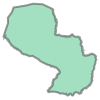

In [215]:
# Load GADM
gadm = gpd.read_file(
    f"data/inputs/gadm36_{code}.gpkg", layer=f'gadm36_{code}_0')
border = gadm['geometry'][0]
border

<AxesSubplot:>

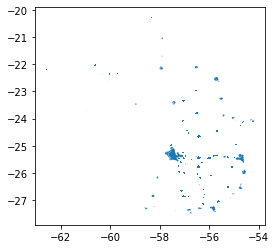

In [216]:
# Load GRUMP
grump_df = gpd.read_file(("data/inputs/grump-v1-urban-ext-polygons-rev02-shp/"
                          "global_urban_extent_polygons_v1.01.shp"))

# Filter Grump to urban areas intersecting GTM
grump_df = grump_df[grump_df.intersects(border)]
grump = list(grump_df['geometry'])
grump_df.plot()

In [217]:
# Load WorldPop dataset
worldpop = rasterio.open(f"data/inputs/{code.lower()}_ppp_2020.tif")
worldpop_img = worldpop.read(1)

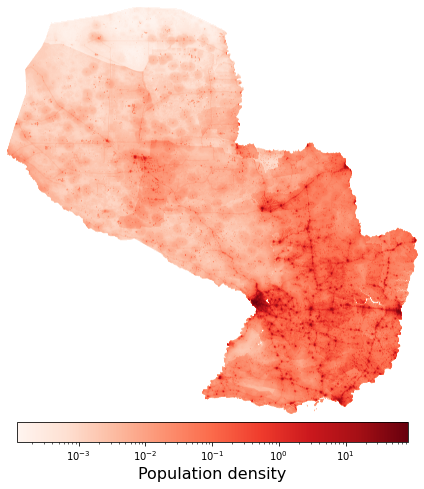

In [218]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(worldpop_img.clip(min=0), norm=colors.LogNorm(), cmap='Reds')
plt.colorbar(fraction=0.045, pad=0.02, orientation='horizontal')
cax = fig.axes[1]
cax.set_xlabel('Population density', fontsize=16)
plt.axis('off')
plt.show()

In [219]:
vmax = worldpop_img.max()

In [220]:
# Mask WorldPop by GRUMP
rural_pop_img, out_transform = rasterio.mask.mask(
    worldpop, grump, crop=False, invert=True)
rural_pop_img = rural_pop_img[0, :, :]

with rasterio.Env():
    with rasterio.open(f'data/{code}/{code}_worldpop_rural.tif', 'w',
                       **worldpop.profile) as dst:
        dst.write(rural_pop_img, 1)

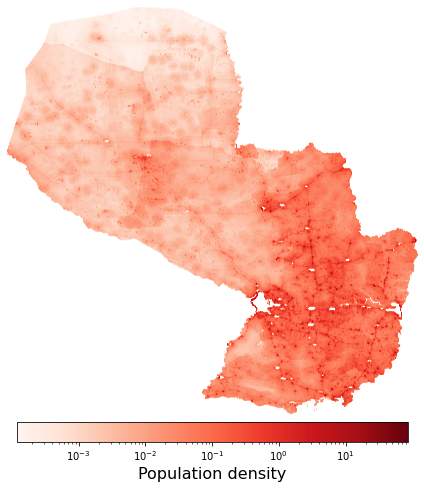

In [221]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(rural_pop_img.clip(min=0), norm=colors.LogNorm(vmax=vmax), cmap='Reds')
plt.colorbar(fraction=0.045, pad=0.02, orientation='horizontal')
cax = fig.axes[1]
cax.set_xlabel('Population density', fontsize=16)
plt.axis('off')
plt.show()

In [222]:
# Load high quality roads from OSM
osm_all_df = gpd.read_file(
    f'data/inputs/{cname}-latest-free.shp/gis_osm_roads_free_1.shp')

In [127]:
osm_all_df = osm_all_df.to_crs(epsg=4326)
for fclass in osm_all_df.fclass.unique():
    l = sum(GEOD.geometry_length(g) for g in osm_all_df[osm_all_df.fclass == fclass].geometry.unary_union)
    print(fclass, ':' , f'{l / 1e3:.1f}', 'km')

primary : 3061.4 km
trunk : 6389.1 km
tertiary : 10943.7 km
residential : 31448.9 km
secondary : 5259.5 km
service : 14440.7 km
steps : 4.3 km
unclassified : 46073.0 km
path : 4029.4 km
pedestrian : 57.2 km
trunk_link : 70.5 km
primary_link : 11.0 km
track_grade4 : 2905.1 km
track : 34161.4 km
track_grade3 : 12773.5 km
secondary_link : 5.0 km
track_grade2 : 7142.7 km
tertiary_link : 5.9 km
track_grade5 : 532.4 km
footway : 515.4 km
living_street : 63.7 km
cycleway : 126.6 km
unknown : 29.5 km
motorway : 11.3 km
track_grade1 : 3.6 km
bridleway : 12.8 km
motorway_link : 2.9 km


<AxesSubplot:>

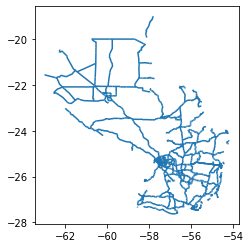

In [223]:
# Filter OSM roads to only primary and secondary, assume those are all
# weather
# osm_df = osm_df[osm_df['fclass'].isin(['primary', 'secondary'])]
osm_df = osm_all_df[osm_all_df['fclass'].isin([
    'motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary',
    'primary_link', 'secondary', 'secondary_link'
])]
osm_df.plot()

<AxesSubplot:>

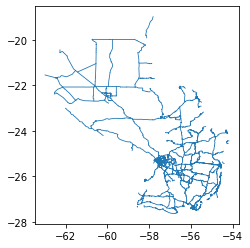

In [224]:
osm_buffers = osm_df.to_crs(epsg=utm_epsg).buffer(2000).to_crs(epsg=4326)
osm_buffers.plot()

In [130]:
osm_df = osm_df.to_crs(epsg=4326)
l = sum(GEOD.geometry_length(g) for g in osm_df.geometry.unary_union)
print('all', ':' , f'{l / 1e3:.1f}', 'km')

osm_roads_len = l

all : 14810.8 km


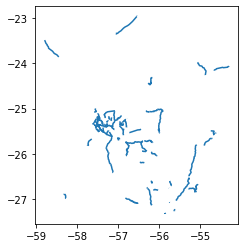

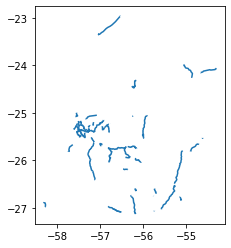

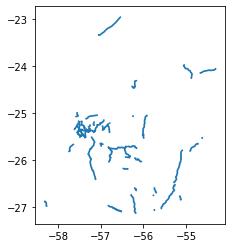

In [227]:
# Read Good matches extracted from HDM4 records
# hdm4_df = gpd.read_file(f'data/{code}/{pfix}_good_matches.gpkg').set_crs(
#     epsg=4326)
hdm4_df = gpd.read_file(f'data/{code}/{pfix}_good_matches.gpkg')
hdm4_df.plot()
hdm4_buffers = hdm4_df.to_crs(epsg=utm_epsg).buffer(2000).to_crs(
    epsg=4326)

# Buffer road dataframe by 2KM
fair_roads_df = hdm4_df[hdm4_df[iri_col] <= 5.0]
fair_roads_df.plot()

fair_buffers = fair_roads_df.to_crs(epsg=utm_epsg).buffer(2000).to_crs(
    epsg=4326)
fair_buffers.plot()

rough_roads_df = hdm4_df[hdm4_df[iri_col] > 5.0]
rough_buffers = fair_roads_df.to_crs(epsg=utm_epsg).buffer(2000).to_crs(
    epsg=4326)

In [132]:
hdm4_df = hdm4_df.to_crs(epsg=4326)
l = sum(GEOD.geometry_length(g) for g in hdm4_df.geometry.unary_union)
print('all', ':' , f'{l / 1e3:.1f}', 'km')

matched_roads_len = l

all : 1695.2 km


In [133]:
fair_roads_df = fair_roads_df.to_crs(epsg=4326)
l = sum(GEOD.geometry_length(g) for g in fair_roads_df.geometry.unary_union)
print('all', ':' , f'{l / 1e3:.1f}', 'km')

fair_roads_len = l

all : 1302.1 km


In [134]:
osm_roads = osm_df.geometry.unary_union
matched_roads = hdm4_df.geometry.unary_union

diff = unary_union(osm_roads.difference(matched_roads))
l = GEOD.geometry_length(diff)
print('all', ':' , f'{l / 1e3:.1f}', 'km')

diff_roads_len = l

all : 13463.3 km


In [135]:
diff2 = unary_union(fair_roads_df.geometry.unary_union.difference(osm_roads))
l = GEOD.geometry_length(diff2)
print('all', ':' , f'{l / 1e3:.1f}', 'km')

all : 252.0 km


In [136]:
print('additional roads', ':' , f'{(osm_roads_len - diff_roads_len) / 1e3:.1f}', 'km')

additional roads : 1347.4 km


In [228]:
# Mask WorldPop by roads
# buffers = unary_union(osm_buffers.geometry.to_list() + grump)
buffers = unary_union(fair_buffers.geometry.to_list() + osm_buffers.geometry.to_list() + grump)

unserved_pop_img, _ = rasterio.mask.mask(
    worldpop, buffers, crop=False, invert=True)
unserved_pop_img = unserved_pop_img[0]

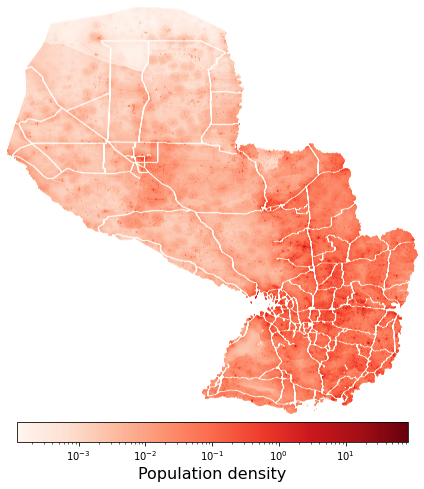

In [229]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(unserved_pop_img.clip(min=0), norm=colors.LogNorm(vmax=vmax), cmap='Reds')
plt.colorbar(fraction=0.045, pad=0.02, orientation='horizontal')
cax = fig.axes[1]
cax.set_xlabel('Population density', fontsize=16)
plt.axis('off')
plt.show()

In [212]:
f'data/{code}/{code}_worldpop_rai.tif'

'data/GTM/GTM_worldpop_rai.tif'

In [211]:
with rasterio.Env():
    with rasterio.open(f'data/{code}/{code}_worldpop_rai.tif', 'w', **worldpop.profile) as dst:
        dst.write(unserved_pop_img, 1)

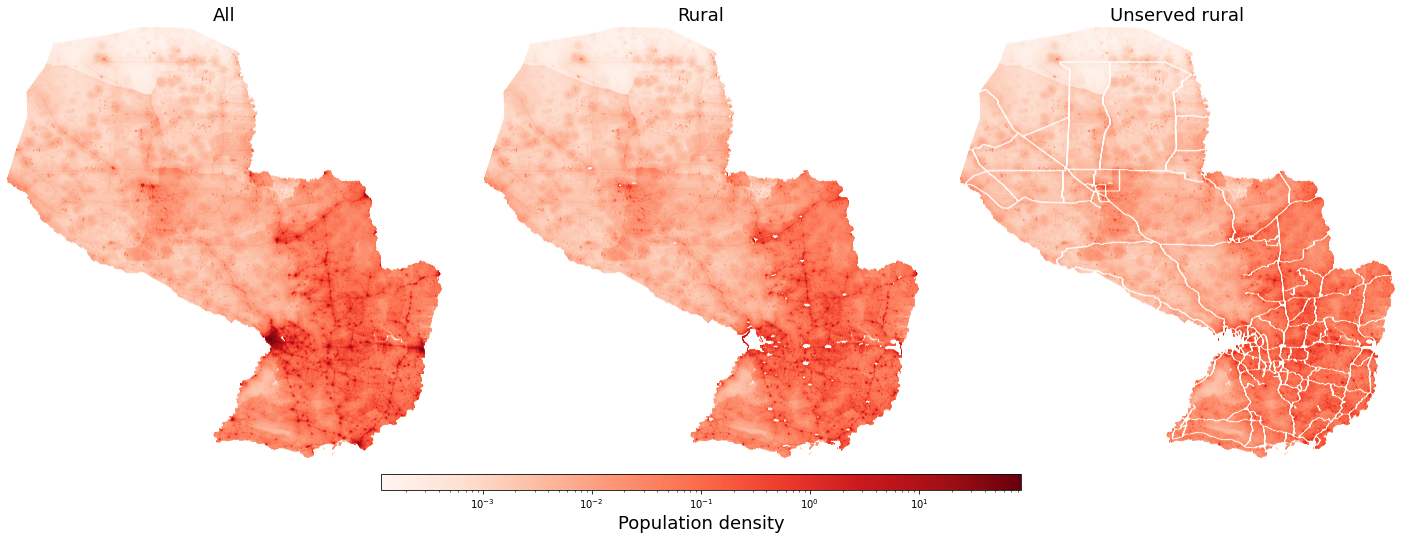

In [187]:
vmax = worldpop_img.max()

fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=3)
fig.tight_layout()

for ax, arr, title in zip(axes.flat, [worldpop_img, rural_pop_img, unserved_pop_img], ['All', 'Rural', 'Unserved rural']):
    im = ax.imshow(arr.clip(min=0), norm=colors.LogNorm(vmax=vmax), cmap='Reds')
    ax.set_title(title, fontdict={'fontsize': 18})
    ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.03, pad=0.03, orientation='horizontal', aspect=40)
cax = fig.axes[-1]
cax.set_xlabel('Population density', fontsize=18)
plt.show()

In [188]:
fig.savefig(f'{pfix}_pop_map.png', bbox_inches='tight', pad_inches=0.2)

In [23]:
# RAI
def calc_rai(rural_pop_img, unserved_pop_img):
    rural_pop = rural_pop_img[rural_pop_img >= 0].sum()
    unserved_pop = unserved_pop_img[unserved_pop_img >= 0].sum()
    rai = (rural_pop - unserved_pop) / rural_pop
    out = {
        'rural_pop': rural_pop,
        'unserved_pop': unserved_pop,
        'served_pop': rural_pop - unserved_pop,
        'rai': rai
    }
    return out

In [184]:
print('OSM only')
calc_rai(rural_pop_img, unserved_pop_img)

OSM only


{'rural_pop': 2856030.2,
 'unserved_pop': 1607864.8,
 'served_pop': 1248165.5,
 'rai': 0.4370281}

In [210]:
print('OSM + matched')
calc_rai(rural_pop_img, unserved_pop_img)

OSM + matched


{'rural_pop': 11658611.0,
 'unserved_pop': 6900781.0,
 'served_pop': 4757830.0,
 'rai': 0.40809578}

In [230]:
print('OSM + matched')
calc_rai(rural_pop_img, unserved_pop_img)

OSM + matched


{'rural_pop': 2856030.2,
 'unserved_pop': 1585194.2,
 'served_pop': 1270836.0,
 'rai': 0.44496587}

In [105]:
4757830.0 - 4564317.0

193513.0

In [185]:
1270836.0 - 1248165.5

22670.5

In [138]:
len(osm_df), f'{osm_roads_len/1e3:.0f} km', len(hdm4_df), f'{matched_roads_len/1e3:.0f} km', len(fair_roads_df), f'{fair_roads_len/1e3:.0f} km'

(11217, '14811 km', 102, '1695 km', 77, '1302 km')

In [181]:
_osm_buffers_df = gpd.GeoDataFrame(geometry=[osm_buffers.geometry.unary_union])
_rough_buffers_df = gpd.GeoDataFrame(geometry=[rough_buffers.geometry.unary_union])
_fair_buffers_df = gpd.GeoDataFrame(geometry=[fair_buffers.geometry.unary_union])
_diff_buffer = gpd.GeoDataFrame(geometry=[_fair_buffers_df.geometry.unary_union.difference(_osm_buffers_df.geometry.unary_union)])
_diff_df = gpd.GeoDataFrame(geometry=[diff2])

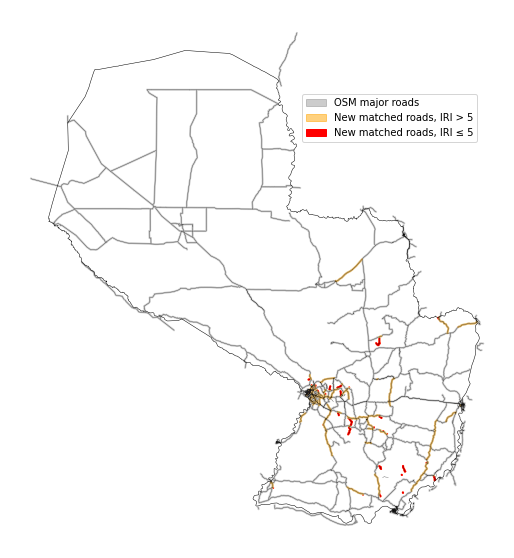

In [192]:
fig = plt.figure(figsize=(10, 10))
if pfix == 'gt':
    bx, by = border.boundary[-1].xy
elif pfix == 'py':
    bx, by = border.boundary.xy
plt.plot(bx, by, color='black', linewidth=0.5)
ax = plt.gca()
_osm_buffers_df.plot(ax=ax, color='gray', alpha=.4, label='OSM major roads')
_rough_buffers_df.plot(ax=ax, color='orange', alpha=.5, label='Matched roads w/ IRI > 5')
_diff_buffer.plot(ax=ax, color='red', alpha=1, label='Matched roads w/ IRI <= 5')
osm_df.plot(ax=ax, linewidth=.25, color='black')
_diff_df.plot(ax=ax, linewidth=.25, color='black')
rough_roads_df.plot(ax=ax, linewidth=.25, color='black')

legend_patches = [
    patches.Patch(color='gray', alpha=.4, label='OSM major roads'),
    patches.Patch(color='orange', alpha=.5, label='New matched roads, IRI > 5'),
    patches.Patch(color='red', alpha=1, label='New matched roads, IRI ≤ 5'),
]
plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(.95, .85))

plt.axis('off')
plt.show()

In [193]:
fig.savefig(f'{pfix}_road_map.png', bbox_inches='tight', pad_inches=0)